## Importing Necessary Libraries

In [1]:
from pandas.tseries.offsets import BDay
import requests
from datetime import timedelta
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense


## Identifying Outliers in last 12 months

In [2]:
def fetch_data(url):
    response = requests.get(url)
    if response.status_code != 200:
        print("Error fetching data:", response.status_code, response.text)
        return None
    data = response.json()
    if 'results' not in data:
        print("No 'results' key in response:", data)
        return None
    return data

def calculate_daily_returns(df, prev_close=None):
    if prev_close is not None:
        df.loc[df.index[0], 'prev_close'] = prev_close
    else:
        df['prev_close'] = df['c'].shift(1)
    df['daily_return'] = (df['c'] - df['prev_close']) / df['prev_close']
    df['abs_daily_return'] = df['daily_return'].abs()
    return df

def get_top_outliers(df, n=10):
    return df.nlargest(n, 'abs_daily_return')

def update_outliers_list(current_df, historical_outliers_df, real_time_outliers_df, n=10):
    if 'source' not in current_df.columns:
        current_df['source'] = 'real-time'
    combined_df = pd.concat([historical_outliers_df, current_df])
    updated_outliers_df = combined_df.nlargest(n, 'abs_daily_return')
    updated_historical_outliers_df = updated_outliers_df[updated_outliers_df['source'] == 'historical']
    updated_real_time_outliers_df = updated_outliers_df[updated_outliers_df['source'] == 'real-time']
    return updated_historical_outliers_df, updated_real_time_outliers_df

def convert_timestamps(df):
    df['date'] = pd.to_datetime(df['t'], unit='ms')
    df.drop(columns=['t'], inplace=True)
    return df

# API key and endpoints
api_key = 'beBybSi8daPgsTp5yx5cHtHpYcrjp5Jq'
today = pd.Timestamp.now().date()
start_date = today - pd.DateOffset(years=1)
start_date_formatted = start_date.strftime('%Y-%m-%d')
end_date = today - pd.DateOffset(days=1)
end_date_formatted = end_date.strftime('%Y-%m-%d')
symbol = 'C:USDCHF'
historical_url = f'https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/day/{start_date_formatted}/{end_date_formatted}?adjusted=true&sort=asc&apiKey={api_key}'
real_time_url = f'https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/day/{today}/{today}?adjusted=true&sort=asc&apiKey={api_key}'

# Fetch and process historical data
historical_data = fetch_data(historical_url)
if historical_data:
    historical_df = pd.DataFrame(historical_data['results'])
    historical_df = convert_timestamps(historical_df)
    historical_df = calculate_daily_returns(historical_df)
    historical_df['source'] = 'historical'
    historical_outliers_df = get_top_outliers(historical_df)
else:
    print("Failed to fetch or process historical data.")

# Fetch and process real-time data
real_time_data = fetch_data(real_time_url)
if real_time_data and 'results' in real_time_data:
    real_time_df = pd.DataFrame(real_time_data['results'])
    real_time_df = convert_timestamps(real_time_df)
    # Use the last close from historical data
    last_close = historical_df['c'].iloc[-1] if not historical_df.empty else None
    real_time_df = calculate_daily_returns(real_time_df, prev_close=last_close)
    real_time_df['source'] = 'real-time'
    updated_historical_outliers_df, updated_real_time_outliers_df = update_outliers_list(real_time_df, historical_outliers_df, pd.DataFrame())
    # Update historical data
    historical_df = pd.concat([historical_df.iloc[1:], real_time_df])  # Keep historical data rolling
else:
    print("No new data available or failed to fetch real-time data.")
    
# Combine data for Top 10 Outliers
full_outlier_df = pd.concat([updated_historical_outliers_df, updated_real_time_outliers_df])

# Print the Outliers
full_outlier_df

,v,vw,o,c,h,l,n,date,prev_close,daily_return,abs_daily_return,source
236,187960,0.8932,0.88558,0.897500,0.89937,0.88360,187960,2024-03-21,0.88555,0.013494,0.013494,historical
120,168024,0.8965,0.90127,0.889100,0.90271,0.88750,168024,2023-11-14,0.90120,-0.013427,0.013427,historical
204,191642,0.8825,0.87580,0.887420,0.88810,0.87520,191642,2024-02-13,0.87581,0.013256,0.013256,historical
163,174820,0.8495,0.85359,0.842500,0.85487,0.84060,174820,2023-12-27,0.85372,-0.013142,0.013142,historical
253,159390,0.9089,0.90297,0.913140,0.91470,0.90260,159390,2024-04-10,0.90303,0.011196,0.011196,historical
296,172177,0.9074,0.91319,0.903320,0.91408,0.90053,172177,2024-05-30,0.91311,-0.010722,0.010722,historical
195,184263,0.8610,0.85760,0.866698,0.86820,0.85510,184263,2024-02-02,0.85760,0.010609,0.010609,historical
5,181573,0.8609,0.85794,0.866230,0.86839,0.85580,181573,2023-07-20,0.85770,0.009945,0.009945,historical
270,180821,0.9142,0.91075,0.919590,0.91965,0.91020,180821,2024-04-30,0.91072,0.009740,0.009740,historical
168,148722,0.8473,0.84185,0.850040,0.85067,0.84150,148722,2024-01-02,0.84192,0.009645,0.009645,historical


In [3]:
sorted_outliers_data = full_outlier_df.sort_values(by="date")
sorted_outliers_data

,v,vw,o,c,h,l,n,date,prev_close,daily_return,abs_daily_return,source
5,181573,0.8609,0.85794,0.866230,0.86839,0.85580,181573,2023-07-20,0.85770,0.009945,0.009945,historical
120,168024,0.8965,0.90127,0.889100,0.90271,0.88750,168024,2023-11-14,0.90120,-0.013427,0.013427,historical
163,174820,0.8495,0.85359,0.842500,0.85487,0.84060,174820,2023-12-27,0.85372,-0.013142,0.013142,historical
168,148722,0.8473,0.84185,0.850040,0.85067,0.84150,148722,2024-01-02,0.84192,0.009645,0.009645,historical
195,184263,0.8610,0.85760,0.866698,0.86820,0.85510,184263,2024-02-02,0.85760,0.010609,0.010609,historical
204,191642,0.8825,0.87580,0.887420,0.88810,0.87520,191642,2024-02-13,0.87581,0.013256,0.013256,historical
236,187960,0.8932,0.88558,0.897500,0.89937,0.88360,187960,2024-03-21,0.88555,0.013494,0.013494,historical
253,159390,0.9089,0.90297,0.913140,0.91470,0.90260,159390,2024-04-10,0.90303,0.011196,0.011196,historical
270,180821,0.9142,0.91075,0.919590,0.91965,0.91020,180821,2024-04-30,0.91072,0.009740,0.009740,historical
296,172177,0.9074,0.91319,0.903320,0.91408,0.90053,172177,2024-05-30,0.91311,-0.010722,0.010722,historical


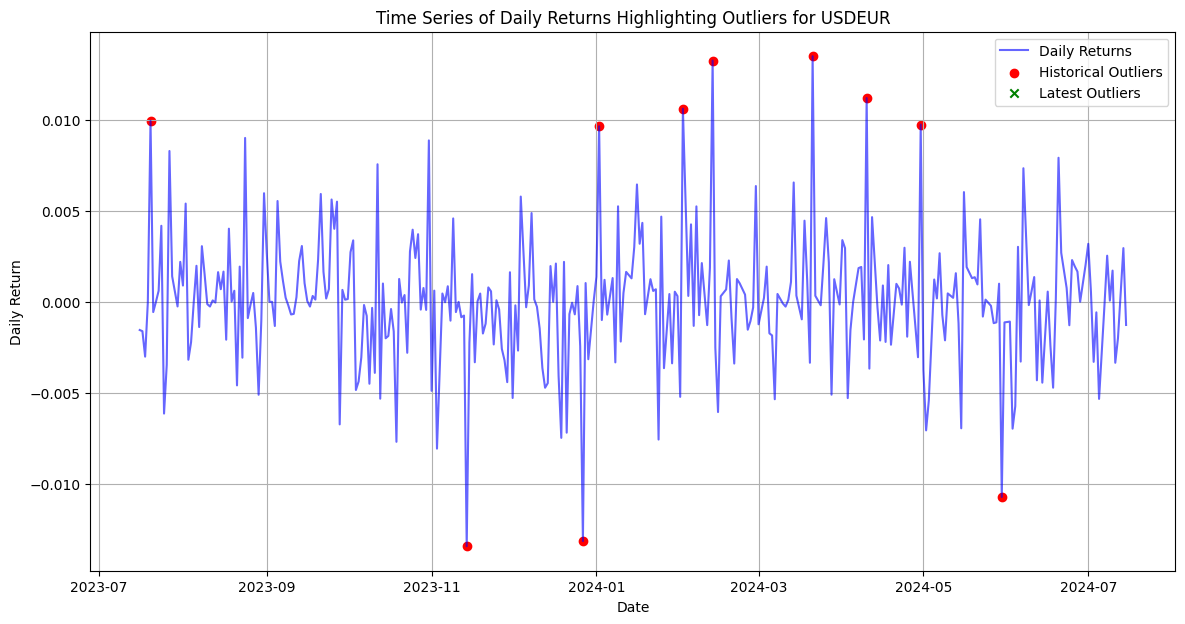

In [4]:
def plot_data_with_outliers(historical_df, historical_outliers_df, real_time_outliers_df):
    plt.figure(figsize=(14, 7))
    plt.plot(historical_df['date'], historical_df['daily_return'], label='Daily Returns', color='blue', alpha=0.6)
    plt.scatter(historical_outliers_df['date'], historical_outliers_df['daily_return'], color='red', label='Historical Outliers')
    plt.scatter(real_time_outliers_df['date'], real_time_outliers_df['daily_return'], color='green', label='Latest Outliers', marker='x')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.title('Time Series of Daily Returns Highlighting Outliers for USDEUR')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot data with outliers
plot_data_with_outliers(historical_df, updated_historical_outliers_df, updated_real_time_outliers_df)

## Fetching Hourly data for 3 days prior and post outlier days

In [5]:
# Convert dates in dataset to datetime objects
sorted_outliers_data['date'] = pd.to_datetime(sorted_outliers_data['date'])

date_ranges = pd.DataFrame({
    "start_date": sorted_outliers_data['date'] - BDay(3),
    "end_date": sorted_outliers_data['date'] + BDay(3),
    "outlier_date": sorted_outliers_data['date'],
})

date_ranges

,start_date,end_date,outlier_date
5,2023-07-17,2023-07-25,2023-07-20
120,2023-11-09,2023-11-17,2023-11-14
163,2023-12-22,2024-01-01,2023-12-27
168,2023-12-28,2024-01-05,2024-01-02
195,2024-01-30,2024-02-07,2024-02-02
204,2024-02-08,2024-02-16,2024-02-13
236,2024-03-18,2024-03-26,2024-03-21
253,2024-04-05,2024-04-15,2024-04-10
270,2024-04-25,2024-05-03,2024-04-30
296,2024-05-27,2024-06-04,2024-05-30


In [6]:
def calculate_daily_returns(df, prev_close=None):
    if prev_close is not None:
        df.loc[df.index[0], 'prev_close'] = prev_close
    else:
        df['prev_close'] = df['c'].shift(1)
    df['returns'] = (df['c'] - df['prev_close']) / df['prev_close']
    return df

def fetch_hourly_data_chunk(symbol, start_date, end_date, api_key):
    formatted_start_date = start_date.strftime('%Y-%m-%d')
    formatted_end_date = end_date.strftime('%Y-%m-%d')

    url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/hour/{formatted_start_date}/{formatted_end_date}?apiKey={api_key}"
    response = requests.get(url)
    
    if response.status_code != 200:
        print(f"Failed to fetch data: {response.status_code} - {response.text}")
        return None
    
    response_data = response.json()
    
    if 'results' not in response_data:
        print(f"No 'results' in response: {response_data}")
        return None

    df = pd.DataFrame(response_data['results'])
    df['date'] = pd.to_datetime(df['t'], unit='ms')
    df.drop(columns=['t'], inplace=True)
    
    return df

def fetch_and_process_hourly_data(symbol, start_date, end_date, api_key):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)
    
    # Split the date range into smaller chunks
    chunk_size = 3  # Fetch data in 7-day chunks
    date_ranges = [(start_date + timedelta(days=i*chunk_size), 
                    min(end_date, start_date + timedelta(days=(i+1)*chunk_size - 1)))
                   for i in range((end_date - start_date).days // chunk_size + 1)]

    # print((end_date - start_date).days // chunk_size + 1)
    all_data = []

    for start, end in date_ranges:
        chunk_data = fetch_hourly_data_chunk(symbol, start, end, api_key)
        if chunk_data is not None:
            all_data.append(chunk_data)
    
    if not all_data:
        print("No data fetched")
        return None
    
    df = pd.concat(all_data)
    hourly_data = calculate_daily_returns(df)
    hourly_data.set_index('date', inplace=True)
    
    full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='H')
    hourly_data = hourly_data.reindex(full_index)
    
    hourly_data.reset_index(inplace=True)
    hourly_data.rename(columns={'index': 'date'}, inplace=True)
    
    return hourly_data


In [7]:
# Initialize empty DataFrame
all_data = pd.DataFrame()

# Initialize an outlier identifier starting from 1 or any specific number
outlier_id = 1

for index, row in date_ranges.iterrows():
    # Convert start_date, end_date, and outlier_date to Timestamp for consistent comparison
    start_date_ts = pd.Timestamp(row['start_date'])
    end_date_ts = pd.Timestamp(row['end_date']) + pd.Timedelta(days=1)  # Extend the end date by one additional day
    outlier_date_ts = pd.Timestamp(row['outlier_date'])
    
    # Get hourly data for the range including 3 days before and after the outlier
    hourly_data = fetch_and_process_hourly_data(symbol, start_date_ts, end_date_ts, api_key)
    # print(hourly_data)
    # Check if hourly_data is not None before processing
    if hourly_data is not None:
        # Assign the current outlier_id to the data
        hourly_data['outlier_id'] = outlier_id

        # Filter out weekdends
        hourly_data = hourly_data[~hourly_data['date'].dt.weekday.isin([5,6])]
        
        # prior_data from start_date to outlier_date inclusive
        prior_data = hourly_data[(hourly_data['date'] >= start_date_ts) & (hourly_data['date'] < outlier_date_ts)]
        prior_data["day type"] = "prior day"

        # outlier_data is for the hourly data on the day of the outlier
        outlier_data = hourly_data[(hourly_data['date'].dt.date == outlier_date_ts.date())]
        outlier_data["day type"] = "outlier day"
        
        # post_data from the day after outlier_date to end_date
        post_outlier_ts = outlier_date_ts + pd.Timedelta(days=1)  # Starting the day after the outlier_date
        post_data = hourly_data[(hourly_data['date'] > post_outlier_ts) & (hourly_data['date'] <= end_date_ts)]
        post_data["day type"] = "post day"
        # print(post_outlier_ts)
        # print(end_date_ts)
        # print(post_data)
        
        # Concatenate the data from this iteration to the cumulative DataFrame
        all_data = pd.concat([all_data, prior_data, outlier_data, post_data])

        # Increment the outlier_id for the next iteration
        outlier_id += 1

    else:
        print(f"Data not available for symbol {symbol} from {row['start_date'].date()} to {row['end_date'].date()}")

# Add the day column to the final DataFrame
all_data['day'] = all_data['date'].dt.day_name()
# Optionally, you can reset the index of the final DataFrame if it becomes non-unique after concatenations
all_data.reset_index(drop=True, inplace=True)

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_15670/28904841.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='H')
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_15670/3555514018.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_15670/3555514018.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

No 'results' in response: {'ticker': 'C:USDCHF', 'queryCount': 0, 'resultsCount': 0, 'adjusted': True, 'status': 'OK', 'request_id': '51d44cef5c70a280080ae30f72df9022'}


/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_15670/28904841.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='H')
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_15670/3555514018.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_15670/3555514018.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

No 'results' in response: {'ticker': 'C:USDCHF', 'queryCount': 0, 'resultsCount': 0, 'adjusted': True, 'status': 'OK', 'request_id': '8d72eb6bcbb33cbd3e00ac4bf28a5ca5'}


/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_15670/28904841.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='H')
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_15670/3555514018.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_15670/3555514018.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

No 'results' in response: {'ticker': 'C:USDCHF', 'queryCount': 0, 'resultsCount': 0, 'adjusted': True, 'status': 'OK', 'request_id': 'c99673b726e69c296e8363723006eb85'}


/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_15670/28904841.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='H')
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_15670/3555514018.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_15670/3555514018.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

## Calculating and comparing similarity scores

In [8]:
def dtw_distance(series1, series2):
    n, m = len(series1), len(series2)
    dtw_matrix = np.zeros((n+1, m+1))
    
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(series1[i-1] - series2[j-1])
            # Take last min from a square sub-matrix
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
            
    return dtw_matrix[n, m]

# Load your data
data = pd.read_csv('USDCHF_hourly.csv')
# Fill null values with ffill then bfill to ensure all nulls are handled
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)
all_data.fillna(method='ffill', inplace=True)
all_data.fillna(method='bfill', inplace=True)

# Filter Prior Day Data
prior_day_data = data[data['day type'] == 'prior day']

# # Main series to compare others against
main = all_data[all_data['day type'] == 'prior day']
ts_main_id = main[main['outlier_id'] == 10]['c'].values

# Calculate DTW distances between the current outlier's series and each of the other outliers
dtw_distances = {}
for id in prior_day_data["outlier_id"].unique():
    series = prior_day_data[prior_day_data['outlier_id'] == id]['c'].values
    distance = dtw_distance(ts_main_id, series)
    dtw_distances[id] = distance

# Sort the distances and get the top 10 lowest
top_10_ids = sorted(dtw_distances, key=dtw_distances.get)[:10]

lowest_dtw = 99999

# Output the results
for id in top_10_ids:
    print(f"DTW Distance between Current Outlier and ID {id}: {dtw_distances[id]:.2f}")
    if dtw_distances[id] < lowest_dtw:
        lowest_dtw = dtw_distances[id]
        best_outlier_match_id = id
    # best_outlier_match_id = min(best_outlier_match_id, dtw_distances[id])

print(best_outlier_match_id)
data_aug = data[data['outlier_id'] == best_outlier_match_id]
print(len(data_aug))

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_15670/971732390.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_15670/971732390.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_15670/971732390.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_data.fillna(method='ffill', inplace=True)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_15670/971732390.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() i

DTW Distance between Current Outlier and ID 131: 0.83
DTW Distance between Current Outlier and ID 132: 1.15
DTW Distance between Current Outlier and ID 111: 1.27
DTW Distance between Current Outlier and ID 133: 1.42
DTW Distance between Current Outlier and ID 134: 1.42
DTW Distance between Current Outlier and ID 112: 1.54
DTW Distance between Current Outlier and ID 140: 1.67
DTW Distance between Current Outlier and ID 135: 1.68
DTW Distance between Current Outlier and ID 113: 1.79
DTW Distance between Current Outlier and ID 114: 1.79
131
168


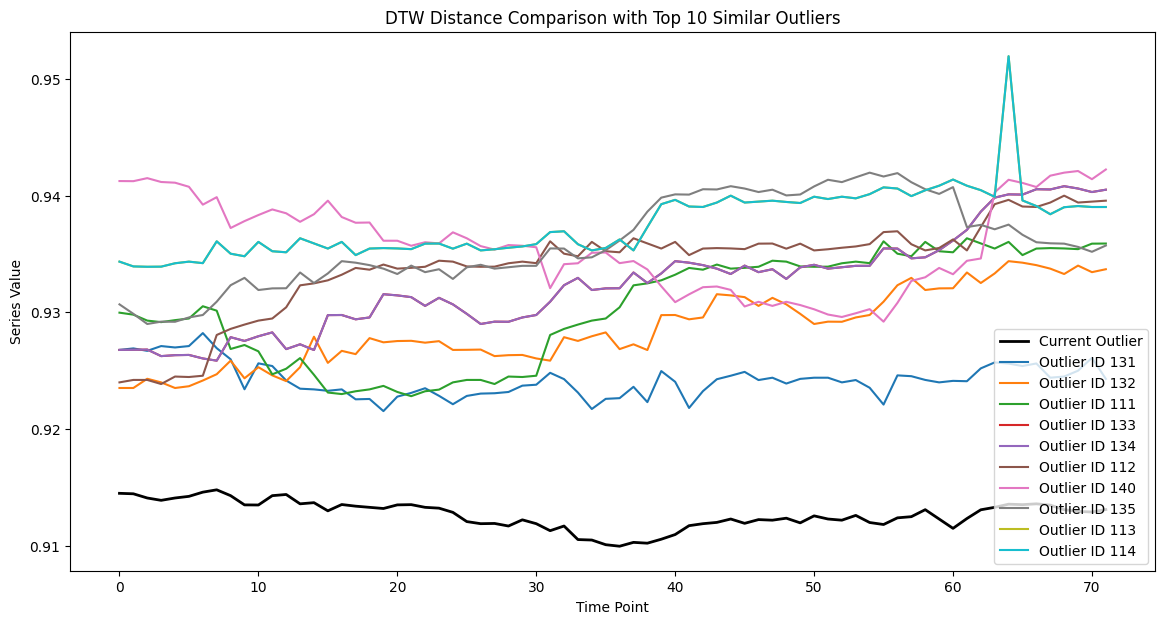

In [9]:
# Prepare the plot
plt.figure(figsize=(14, 7))
plt.plot(ts_main_id, label='Current Outlier', linewidth=2, color='black')

# Plot each series in the top 10
for id in top_10_ids:
    series = prior_day_data[prior_day_data['outlier_id'] == id]['c'].values
    plt.plot(series, label=f'Outlier ID {id}')

plt.title('DTW Distance Comparison with Top 10 Similar Outliers')
plt.xlabel('Time Point')
plt.ylabel('Series Value')
plt.legend()
plt.show()

In [10]:
data_aug.drop(columns=["Unnamed: 0", "n", "prev_close", "returns", "outlier_id", "day"], inplace=True)
# Reset the index
data_aug.reset_index(drop=True, inplace=True)

data_aug

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_15670/1620346511.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_aug.drop(columns=["Unnamed: 0", "n", "prev_close", "returns", "outlier_id", "day"], inplace=True)


,date,v,vw,o,c,h,l,day type
0,2022-12-29 00:00:00,5285.0,0.9274,0.927710,0.926780,0.927870,0.926500,prior day
1,2022-12-29 01:00:00,7937.0,0.9269,0.926710,0.926910,0.927209,0.926500,prior day
2,2022-12-29 02:00:00,4498.0,0.9268,0.926920,0.926700,0.927080,0.926400,prior day
3,2022-12-29 03:00:00,3843.0,0.9271,0.926910,0.927110,0.927400,0.926578,prior day
4,2022-12-29 04:00:00,3181.0,0.9272,0.927210,0.926990,0.927600,0.926700,prior day
5,2022-12-29 05:00:00,4621.0,0.9271,0.927010,0.927110,0.927600,0.926600,prior day
6,2022-12-29 06:00:00,4640.0,0.9276,0.927140,0.928220,0.928470,0.926700,prior day
7,2022-12-29 07:00:00,5903.0,0.9281,0.928400,0.926930,0.928740,0.926700,prior day
8,2022-12-29 08:00:00,8242.0,0.9261,0.926930,0.925980,0.927210,0.924800,prior day
9,2022-12-29 09:00:00,7806.0,0.9247,0.925980,0.923410,0.925980,0.922700,prior day


## Augmenting Data for the choosen historical outlier

In [11]:
# Define the autoencoder model
def create_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(encoded)
    output_layer = Dense(input_dim, activation='sigmoid')(decoded)  # Use sigmoid if scaled [0,1]
    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Prepare the data
features = ['v', 'vw', 'o', 'c', 'h', 'l']  # Specify the features to augment
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_aug[features])

# Train the autoencoder
autoencoder = create_autoencoder(data_scaled.shape[1])
autoencoder.fit(data_scaled, data_scaled, epochs=100, batch_size=32, shuffle=True, verbose=1)

# Generate synthetic data
synthetic_data = []
for _ in range(10):
    noise = np.random.normal(0, 0.1, data_scaled.shape)
    synthetic_data_scaled = autoencoder.predict(data_scaled + noise)
    synthetic_data.append(scaler.inverse_transform(synthetic_data_scaled))

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0918  
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0917 
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0840 
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0762 
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0730 
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0639 
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0569 
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0510 
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0416 
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 0.0310
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 0.0244
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0182 
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - loss: 0.0135
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 0.0118
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 0.0093
Epoch 16/100


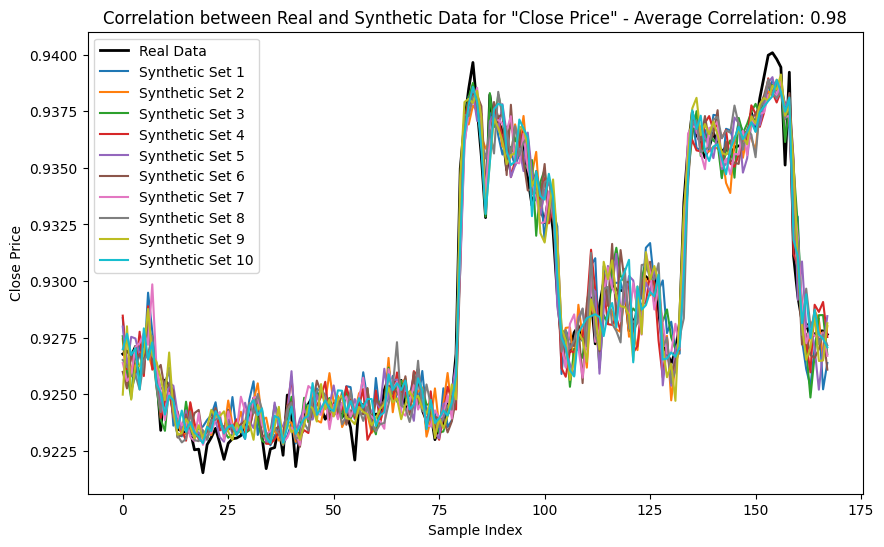

In [12]:
# Extract the 'c' column index from your features list
c_index = features.index('c')

# Extract the 'c' column from the real data
real_c = data_aug['c'].values

# Prepare to store correlations for averaging
correlations = []

# Plot the real 'c' column
plt.figure(figsize=(10, 6))
plt.plot(real_c, label='Real Data', linewidth=2, color='black')

# Extract and plot the 'c' column from each synthetic dataset
for i, synth in enumerate(synthetic_data):
    synthetic_c = synth[:, c_index]
    plt.plot(synthetic_c, label=f'Synthetic Set {i+1}')
    
    # Calculate the correlation between real and synthetic 'c' values
    correlation = np.corrcoef(real_c, synthetic_c)[0, 1]
    correlations.append(correlation)

# Calculate the average correlation
average_correlation = np.mean(correlations)

# Update the title with average correlation
plt.title(f'Correlation between Real and Synthetic Data for "Close Price" - Average Correlation: {average_correlation:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [13]:
# Initialize an outlier identifier starting from 1 or any specific number
outlier_id = 1

# Initialize an empty list to hold the individual synthetic dataframes
synthetic_dfs = []

# Iterate over each synthetic dataset
for i, synthetic in enumerate(synthetic_data):
    # Create a DataFrame from the synthetic data
    df = pd.DataFrame(synthetic, columns=features)
    # Add the 'day type' column from the existing 'data' DataFrame
    df['day type'] = data_aug['day type'].values  # Adjust as needed if 'day type' is not aligned
    # Add the outlier_id column
    df['outlier_id'] = outlier_id
    # Increment the outlier_id for the next iteration
    outlier_id += 1
    # Append the DataFrame to the list
    synthetic_dfs.append(df)

# Concatenate all the individual DataFrames into a single DataFrame
combined_df = pd.concat(synthetic_dfs, ignore_index=True)

# Create a DataFrame from data_aug with outlier_id = 0
data_aug_df = data_aug[features + ['day type']].copy()
data_aug_df['outlier_id'] = 0

# Concatenate the synthetic DataFrames with the data_aug DataFrame
df_train = pd.concat([data_aug_df, combined_df, ], ignore_index=True)

# Ensure the order of columns is consistent
df_train = df_train[features + ['outlier_id', 'day type']]

In [14]:
df_train

,v,vw,o,c,h,l,outlier_id,day type
0,5285.000000,0.927400,0.927710,0.926780,0.927870,0.926500,0,prior day
1,7937.000000,0.926900,0.926710,0.926910,0.927209,0.926500,0,prior day
2,4498.000000,0.926800,0.926920,0.926700,0.927080,0.926400,0,prior day
3,3843.000000,0.927100,0.926910,0.927110,0.927400,0.926578,0,prior day
4,3181.000000,0.927200,0.927210,0.926990,0.927600,0.926700,0,prior day
5,4621.000000,0.927100,0.927010,0.927110,0.927600,0.926600,0,prior day
6,4640.000000,0.927600,0.927140,0.928220,0.928470,0.926700,0,prior day
7,5903.000000,0.928100,0.928400,0.926930,0.928740,0.926700,0,prior day
8,8242.000000,0.926100,0.926930,0.925980,0.927210,0.924800,0,prior day
9,7806.000000,0.924700,0.925980,0.923410,0.925980,0.922700,0,prior day


## Predictive Modeling

### Fetching 3 days prior and post data for the latest outlier for vailidating predictions

In [15]:
# Convert start_date, end_date, and outlier_date to Timestamp for consistent comparison
start_date_co = pd.Timestamp(date_ranges['start_date'].iloc[-1])
end_date_co = pd.Timestamp(date_ranges['end_date'].iloc[-1]) + pd.Timedelta(days=1)  # Extend the end date by one additional day
outlier_date_co = pd.Timestamp(date_ranges['outlier_date'].iloc[-1])

# Filter out weekdends
hourly_data = hourly_data[~hourly_data['date'].dt.weekday.isin([5,6])]

# prior_data from start_date to outlier_date inclusive
df_prior = hourly_data[(hourly_data['date'] >= start_date_co) & (hourly_data['date'] < outlier_date_co)]
df_prior["day type"] = "prior day"

# outlier_data is for the hourly data on the day of the outlier
df_outlier = hourly_data[(hourly_data['date'].dt.date == outlier_date_co.date())]
df_outlier["day type"] = "outlier day"

# post_data from the day after outlier_date to end_date
post_outlier_co = outlier_date_co + pd.Timedelta(days=1)  # Starting the day after the outlier_date
df_post = hourly_data[(hourly_data['date'] > post_outlier_co) & (hourly_data['date'] <= end_date_co)]
df_post["day type"] = "post day"

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_15670/438948252.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prior["day type"] = "prior day"
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_15670/438948252.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outlier["day type"] = "outlier day"
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_15670/438948252.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

### Model training and prediction

In [16]:
# Function to prepare sequences for training
def prepare_sequences(df):
    sequences = []
    labels = []
    
    unique_ids = df['outlier_id'].unique()
    
    for oid in unique_ids:
        prior_data = df[(df['outlier_id'] == oid) & (df['day type'] == 'prior day')]['c'].values
        post_data = df[(df['outlier_id'] == oid) & (df['day type'] == 'post day')]['c'].values
        
        if len(prior_data) == 72 and len(post_data) >= 72:
            sequences.append(prior_data)
            labels.append(post_data[:72])
        else:
            print(f"Skipping outlier_id {oid} due to insufficient prior or post data")
    return np.array(sequences), np.array(labels)

def train_model(df_train):
	df_train.fillna(method='ffill', inplace=True)
	df_train.fillna(method='bfill', inplace=True)
	scaler = MinMaxScaler(feature_range=(0, 1))
	df_train['c'] = scaler.fit_transform(df_train[['c']])

	X_train, y_train = prepare_sequences(df_train)
	X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

	model = Sequential([
		LSTM(50, return_sequences=True, input_shape=(72, 1)),
		LSTM(50),
		Dense(72)
	])
	model.compile(optimizer=Adam(learning_rate=0.005), loss='mean_squared_error')
	model.fit(X_train, y_train, epochs=2500, batch_size=64, verbose=2)
	return model, scaler

# Function to prepare a single sequence for prediction
def prepare_sequence_predict(df_prior, scaler):
	df_prior.drop(columns= ['prev_close', 'returns', 'n'], inplace=True)
	df_prior.fillna(method='ffill', inplace=True)
	df_prior.fillna(method='bfill', inplace=True)
	prior_data = df_prior['c'].values # "df_prior" should be the dataframe containing prior day's data for the current outlier.
	prior_data = scaler.transform(prior_data.reshape(-1, 1)).flatten()
	return prior_data.reshape(1, 72, 1)

# Function to predict using the model
def predict(model, df_prior, scaler):
    X_test = prepare_sequence_predict(df_prior, scaler)
    predictions = model.predict(X_test)
    return scaler.inverse_transform(predictions.reshape(-1, 1))

# Function to validate predictions
def validate_predictions(predictions, df_post, scaler):
	df_post.drop(columns= ['prev_close', 'returns', 'n'], inplace=True)
	df_post.fillna(method='ffill', inplace=True)
	df_post.fillna(method='bfill', inplace=True)
	post_data = df_post['c'].values[:72] # "df_post" should be the dataframe containing post day's data for the current outlier.
	post_data_scaled = scaler.transform(post_data.reshape(-1, 1)).flatten()

	mse = mean_squared_error(post_data_scaled, predictions.flatten())
	mae = mean_absolute_error(post_data_scaled, predictions.flatten())
	rmse = np.sqrt(mse)
	r2 = r2_score(post_data_scaled, predictions.flatten())
	
	return mse, mae, rmse, r2

# Example usage:
model, scaler = train_model(df_train)
predictions = predict(model, df_prior, scaler)
mse, mae, rmse, r2 = validate_predictions(predictions, df_post, scaler)

Epoch 1/2500


/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_15670/813155766.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train.fillna(method='ffill', inplace=True)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_15670/813155766.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train.fillna(method='bfill', inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 - 2s - 2s/step - loss: 0.3677
Epoch 2/2500
1/1 - 0s - 40ms/step - loss: 0.3487
Epoch 3/2500
1/1 - 0s - 59ms/step - loss: 0.3182
Epoch 4/2500
1/1 - 0s - 51ms/step - loss: 0.2453
Epoch 5/2500
1/1 - 0s - 57ms/step - loss: 0.1573
Epoch 6/2500
1/1 - 0s - 37ms/step - loss: 0.1337
Epoch 7/2500
1/1 - 0s - 37ms/step - loss: 0.0841
Epoch 8/2500
1/1 - 0s - 37ms/step - loss: 0.0463
Epoch 9/2500
1/1 - 0s - 36ms/step - loss: 0.0302
Epoch 10/2500
1/1 - 0s - 35ms/step - loss: 0.0228
Epoch 11/2500
1/1 - 0s - 49ms/step - loss: 0.0170
Epoch 12/2500
1/1 - 0s - 91ms/step - loss: 0.0140
Epoch 13/2500
1/1 - 0s - 36ms/step - loss: 0.0139
Epoch 14/2500
1/1 - 0s - 34ms/step - loss: 0.0146
Epoch 15/2500
1/1 - 0s - 34ms/step - loss: 0.0146
Epoch 16/2500
1/1 - 0s - 36ms/step - loss: 0.0134
Epoch 17/2500
1/1 - 0s - 35ms/step - loss: 0.0117
Epoch 18/2500
1/1 - 0s - 35ms/step - loss: 0.0103
Epoch 19/2500
1/1 - 0s - 37ms/step - loss: 0.0093
Epoch 20/2500
1/1 - 0s - 53ms/step - loss: 0.0085
Epoch 21/2500
1/1 - 0s -

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_15670/813155766.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prior.drop(columns= ['prev_close', 'returns', 'n'], inplace=True)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_15670/813155766.py:40: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prior.fillna(method='ffill', inplace=True)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_15670/813155766.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prior.fillna(method='ffill', inp

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_15670/813155766.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_post.drop(columns= ['prev_close', 'returns', 'n'], inplace=True)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_15670/813155766.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_post.fillna(method='ffill', inplace=True)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_15670/813155766.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_post.fillna(method='ffill', inplac

In [17]:
# Now you can print these values in a different cell
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

Mean Squared Error: 4.776130521981205
Mean Absolute Error: 2.1682126290491675
Root Mean Squared Error: 2.185436002719184
R-squared: -61.05660640412392
